In [1]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler as sk_minmax
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from collections import OrderedDict
from pprint import pprint
from river import anomaly, preprocessing, compose, ensemble, neighbors, datasets
from river.utils import numpy2dict
import matplotlib.pyplot as plt
import numpy as np
from math import floor


Bad key "text.kerning_factor" on line 4 in
C:\Users\MARCELO\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# LOAD DATA

In [46]:
columns = ['w', 'q_chamber1_cilinda', 'q_chamber1_cilindb', 'q_chamber2_cilinda', 'q_chamber2_cilindb', 'q_pressureline_leftailc1', 'q_pressureline_leftailc2', 'q_tank_leftailc1', 'q_tank_leftailc2', 'f_cilinda', 'f_cilindb', 'x_cilinda', 'x_cilindb', 'p_chamber1_cilinda', 'p_chamber1_cilindb', 'p_chamber2_cilinda', 'p_chamber2_cilindb', 'p_pressureline_leftailc1', 'p_pressureline_leftailc2', 'p_tank_leftailc1', 'p_tank_leftailc2', 't', 'v_cilinda', 'v_cilindb', 'y_servo_valve']

## DATASET 1 - ALTITUDE MANEUVER

In [234]:
data_ds1_normal = pd.read_csv('dataset/F16_DS1_ALTITUDE/F16_DS1_normal.csv', names=columns)
data_ds1_fault1 = pd.read_csv('dataset/F16_DS1_ALTITUDE/F16_DS1_fault1_leakage.csv', names=columns)
data_ds1_fault2 = pd.read_csv('dataset/F16_DS1_ALTITUDE/F16_DS1_fault2_viscousfriction.csv', names=columns)
data_ds1_fault3 = pd.read_csv('dataset/F16_DS1_ALTITUDE/F16_DS1_fault3_compressibility.csv', names=columns)
data_ds1_fault4 = pd.read_csv('dataset/F16_DS1_ALTITUDE/F16_DS1_fault4_fixedposition.csv', names=columns)

data_ds1_normal['y'] = 0
data_ds1_fault1['y'] = 1
data_ds1_fault2['y'] = 2
data_ds1_fault3['y'] = 3
data_ds1_fault4['y'] = 4

## DATASET 2 - ROLL MANEUVER + TORQUE SURFACE

In [235]:
data_ds2_normal = pd.read_csv('dataset/F16_DS2_W_TS/F16_DS2_normal.csv', names=columns)
data_ds2_fault1 = pd.read_csv('dataset/F16_DS2_W_TS/F16_DS2_fault1_leakage.csv', names=columns)
data_ds2_fault2 = pd.read_csv('dataset/F16_DS2_W_TS/F16_DS2_fault2_viscousfriction.csv', names=columns)
data_ds2_fault3 = pd.read_csv('dataset/F16_DS2_W_TS/F16_DS2_fault3_compressibility.csv', names=columns)
data_ds2_fault4 = pd.read_csv('dataset/F16_DS2_W_TS/F16_DS2_fault4_fixedposition.csv', names=columns)

data_ds2_normal['y'] = 0
data_ds2_fault1['y'] = 1
data_ds2_fault2['y'] = 2
data_ds2_fault3['y'] = 3
data_ds2_fault4['y'] = 4

## Adjust Normal Operation

- first 20 seconds (200 samples at 10hz) are normal operations!

In [236]:
datasets = [data_ds1_fault1, data_ds1_fault2, data_ds1_fault3, data_ds1_fault4, data_ds2_fault1, data_ds2_fault2, data_ds2_fault3, data_ds2_fault4]

for dataset in datasets:
    for x in np.arange(dataset.shape[0]/1401, dtype=int): #0-149
        k = x * 1401
        dataset[k:k+200] = 0

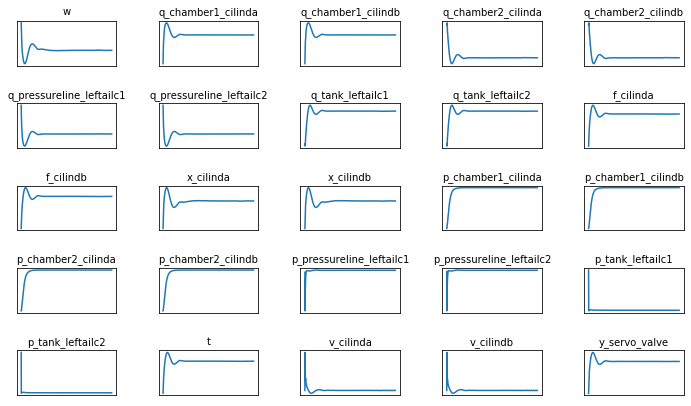

In [3]:
sample = 299

fig, axs = plt.subplots(5, 5, figsize=(10, 6))
for i in np.arange(0, 25):
    r = floor(i / 5)
    c = i % 5

    axs[r,c].plot(data.iloc[1401*(sample-1):sample*1401, i])
    axs[r,c].set_title(columns[i], fontsize=10)
    axs[r,c].get_xaxis().set_ticks([])
    axs[r,c].get_yaxis().set_ticks([])

plt.tight_layout(pad=2, w_pad=2, h_pad=2)

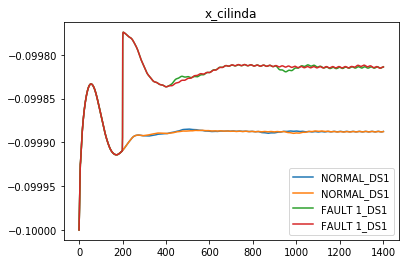

In [14]:
points = 1401

column = 11

i_sample_1 = 1
i_sample_2 = 59
i_sample_3 = 69
i_sample_4 = 136

sample_1 = data.iloc[points*(i_sample_1-1):points*i_sample_1, column].values
sample_2 = data.iloc[points*(i_sample_2-1):points*i_sample_2, column].values

sample_3 = data_ds1_fault1.iloc[points*(i_sample_3-1):points*i_sample_3, column].values
sample_4 = data_ds1_fault1.iloc[points*(i_sample_4-1):points*i_sample_4, column].values

a = pd.DataFrame([sample_1, sample_2, sample_3, sample_4])

plt.plot(a.iloc[0, :])
plt.plot(a.iloc[1, :])
plt.plot(a.iloc[2, :])
plt.plot(a.iloc[3, :])

plt.title(columns[column])
plt.legend(['NORMAL_DS1','NORMAL_DS1','FAULT 1_DS1','FAULT 1_DS1'])

In [105]:
a = pd.DataFrame([sample_1, sample_2, sample_3, sample_4])
a

0         1         2          3          4          5     \
0  1.127570e-17  3.610846  7.242804  10.551878  13.631753  16.507052   
1  1.127570e-17  3.610846  7.242804  10.551878  13.631753  16.507052   
2  1.127570e-17  3.610846  7.242804  10.551878  13.631753  16.507052   
3  1.127570e-17  3.610846  7.242804  10.551878  13.631753  16.507052   

        6          7          8         9     ...       1391       1392  \
0  19.208894  21.782355  24.175486  26.41495  ...  54.877175  54.876957   
1  19.208894  21.782355  24.175486  26.41495  ...  54.857181  54.856825   
2  19.208894  21.782355  24.175486  26.41495  ...  54.250667  54.249456   
3  19.208894  21.782355  24.175486  26.41495  ...  54.293572  54.289443   

        1393       1394       1395       1396       1397       1398  \
0  54.876621  54.876181  54.875656  54.875069  54.874446  54.873814   
1  54.856350  54.855765  54.855085  54.854328  54.853517  54.852677   
2  54.248094  54.246641  54.245162  54.243721  54.242382  54.241206   
3  54.285477  54.281739  54.278290  54.275179  54.272446  54.270118   

        1399       1400  
0  54.873201  54.872634  
1  54.851835  54.851019  
2  54.240244  54.239539  
3  54.268208  54.266713  

[4 rows x 1401 columns]

# EXPERIMENT 1

- Detector Phase with Normalization (only Normal data)

## train test split

In [246]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_ds1_normal.iloc[:, :-1], data_ds1_normal.iloc[:, -1], test_size=0.99, random_state=42)

## normalization

In [247]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train = ss.fit_transform(X_train)

## Autoencoder (PyTorch)

In [239]:
#!pip install fastai
from sklearn.preprocessing import StandardScaler
import math
import torch
from torch import nn
import numpy as np
from sklearn.metrics import confusion_matrix
from torchvision import transforms
from fastai.vision.all import show_image
import matplotlib.pyplot as plt

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(25, 12),
            nn.ReLU(),
            nn.Linear(12, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 12),
            nn.ReLU(),
            nn.Linear(12, 25),
            nn.Tanh()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [240]:
def train(net, train_loader, num_epochs, optimizer, loss_function):
    train_loss = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for n, (real_samples, _) in enumerate(train_loader):

            net.zero_grad()

            ### forward ###
            output = net(real_samples.type(torch.FloatTensor))

            loss = loss_function(
                output, real_samples.type(torch.FloatTensor)
            )
            running_loss += loss.item()

            ### backward ###
            loss.backward()
            optimizer.step()

        step_loss = running_loss / len(train_loader)
        train_loss.append(step_loss)
        ### log ###
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss))

    return net, output, train_loss

In [248]:
# main
net = Autoencoder()
lr = 1e-3
num_epochs = 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-5)
loss_function = nn.MSELoss()
batch_size = 32
torch.manual_seed(111)

In [249]:
train_set = [
    (X_train, X_train) for i in range(len(X_train))
]
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

In [250]:
net, output, loss = train(net, train_loader, num_epochs, optimizer, loss_function)

epoch [1/15], loss:0.6883
epoch [2/15], loss:0.6342
epoch [3/15], loss:0.6279
epoch [4/15], loss:0.6264
epoch [5/15], loss:0.6254
epoch [6/15], loss:0.6246
epoch [7/15], loss:0.6239
epoch [8/15], loss:0.6231
epoch [9/15], loss:0.6223
epoch [10/15], loss:0.6217
epoch [11/15], loss:0.6213
epoch [12/15], loss:0.6210
epoch [13/15], loss:0.6208
epoch [14/15], loss:0.6206
epoch [15/15], loss:0.6204


Text(0, 0.5, 'Loss')

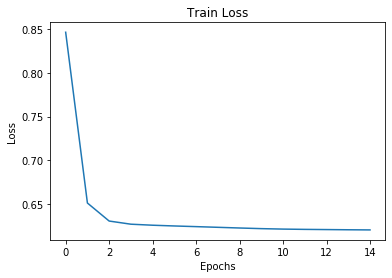

In [251]:
plt.figure()
plt.plot(loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [252]:
y_hat = []
ground_truth = []
data_test = [X_test, data_ds1_fault1, data_ds1_fault2]

for k, i in enumerate(data_test):

    for j, x in data_test[k].iloc[:10000].iterrows():
        if k == 0:
            ground_truth.append(0)
        else:
            if x[-1] == 0:
                ground_truth.append(0)
            else:
                ground_truth.append(1)
            x = x.iloc[:-1]

        real = ss.transform(x.to_numpy().reshape(1,-1)).astype(np.float32)

        regenerate = net(torch.from_numpy(real))

        loss = loss_function(regenerate, torch.from_numpy(real)).cpu().detach().numpy()

        if loss < 2:
            y_hat.append(0)
        else:
            y_hat.append(1)


confusion_matrix(ground_truth, y_hat, normalize='true')

C:\Users\MARCELO\anaconda3\lib\site-packages\sklearn\base.py:446: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
C:\Users\MARCELO\anaconda3\lib\site-packages\sklearn\base.py:446: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
C:\Users\MARCELO\anaconda3\lib\site-packages\sklearn\base.py:446: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
C:\Users\MARCELO\anaconda3\lib\site-packages\sklearn\base.py:446: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
C:\Users\MARCELO\anaconda3\lib\site-packages\sklearn\base.py:446: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature n

array([[0.71318065, 0.28681935],
       [0.07850601, 0.92149399]])